# Load Environment

In [145]:
%load_ext autoreload
%autoreload 2
%pylab
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format='svg'
import seaborn
seaborn.reset_orig()
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 4

import numpy as np
from optalg.opt_solver import *
import scipy.io # to read matlab files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [146]:
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import mppfnet
import gridopt
import pfnet

# Load Network

In [147]:
# Construct multi-period network and load topology
mp = MPNetwork(timesteps=168)
#mp.base_power = 1e-6 # 1kW base power
mp.load('./data/case32.art')

In [148]:
# Load EEX prices
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]])
eex_prices.shape
# Set prices to EEX prices
mp.set_prices(eex_prices)

# Load Profiles
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

## Generate Vargen Profiles

In [149]:
mp.generate_solar_profiles()

# Construct Optimization Problem

In [150]:
# bus voltage angles
mp.set_flags(pfnet.OBJ_BUS, pfnet.FLAG_VARS, pfnet.BUS_PROP_NOT_SLACK, pfnet.BUS_VAR_VANG)

# Batteries must be variables
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS, pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS, pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)

# Mark Gen, Load and Vargen as variables
mp.set_flags(pfnet.OBJ_LOAD, pfnet.FLAG_VARS, pfnet.LOAD_PROP_ANY, pfnet.LOAD_VAR_P)
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS,pfnet.GEN_PROP_ANY, pfnet.GEN_VAR_P)
mp.set_flags(pfnet.OBJ_VARGEN, pfnet.FLAG_VARS, pfnet.VARGEN_PROP_ANY, pfnet.VARGEN_VAR_P)

# slack gens active powers
#mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)

# gens active powers
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)

# Battery Bounds
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

# Fix Load
mp.set_flags(pfnet.OBJ_LOAD, pfnet.FLAG_FIXED, pfnet.LOAD_PROP_ANY, pfnet.LOAD_VAR_P)

# Fix Vargen
mp.set_flags(pfnet.OBJ_VARGEN, pfnet.FLAG_FIXED, pfnet.VARGEN_PROP_ANY, pfnet.VARGEN_VAR_P)

# Construct Problem
p = MPProblem(mp)
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)  # generator bounds
p.add_constraint(pfnet.CONSTR_TYPE_DCPF)  # power flow
p.add_constraint(pfnet.CONSTR_TYPE_FIX) # fix load and vargen
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN) # battery dynamic constraints

p.analyze()
x = p.get_init_point()
p.eval(x)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [151]:
# Helper variables
nx = mp.networks[0].num_vars

# Show information about network
mp.show_components()

Network Components
-----------------------------
timesteps:           : 168
------- per timestep --------
buses:               : 31
   slack:            : 1
   reg by gen:       : 1
   reg by tran:      : 1
   reg by shunt:     : 0
shunts:              : 0
   fixed:            : 0
   switched v:       : 0
branches:            : 30
   lines:            : 29
   fixed trans:      : 0
   phase shifters    : 0
   tap changers v    : 1
   tap changers Q    : 0
generators:          : 1
   slack:            : 1
   reg:              : 1
   P adjust          : 1
loads:               : 19
   P adjust:         : 0
vargens:             : 2
batteries:           : 3


# Construct optimization problem for linear solver

In [152]:
from optalg.opt_solver.lp_cvxopt import OptSolverLP_CVXOPT
from optalg.opt_solver.linear_problem import LinProblem
from scipy.sparse import triu

Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x

g = gx / mp.base_power
        
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u

problem = QuadProblem(H, g, A, b, l, u, x=p.x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-8})
problem.show()

## Solve Optimization Problem

In [153]:
solver.solve(problem)
print(solver.get_status())
problem.x


Solver: IQP
-----------
iter    phi      fmax      gmax       cu       cl       s    
 0  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  0.0e+00 
 1  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  4.9e-09 
 2  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  7.7e-09 
 3  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  1.9e-08 
 4  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  3.6e-08 
 5  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  1.3e-07 
 6  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  2.7e-07 
 7  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  1.1e-06 
 8  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  2.6e-06 
 9  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  1.1e-05 
10  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  2.5e-05 
11  2.67e-02  9.57e+00  9.57e+03  1.0e+01  1.0e+01  1.1e-04 
12  2.67e-02  9.56e+00  9.57e+03  1.0e+01  1.0e+01  3.1e-04 
13  2.66e-02  9.52e+00  1.79e+04  1.0e+01  1.0e+01  4.8e-03 
14  2.65e-02  9.48e+00  9.48e+03  9.9e+00  9.9e+00  3.8e-03

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

## Attempt to solve the problem with ECOS

In [154]:
#import ecos
#import scipy
#dims = dict(l=9744, q=[])
#G = scipy.sparse.coo_matrix(([], [[], []]), shape=(9744,9744))
#h = zeros((9744,))
#solution = ecos.solve(g,G,h,dims, A=p.A,b=p.b,)

## Store Solver Result

In [155]:
mp.set_var_values(solver.get_primal_variables())

# Output

## Battery SOC

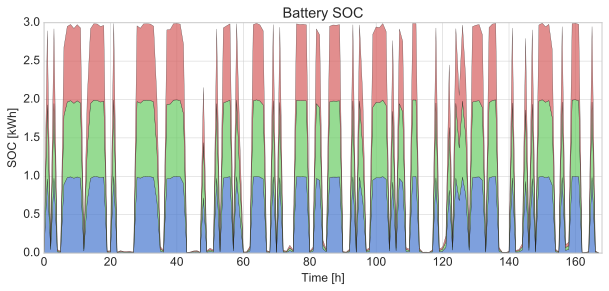

In [156]:
%aimport pfvis

pfvis.plot_battery_soc(mp)


## Battery Power

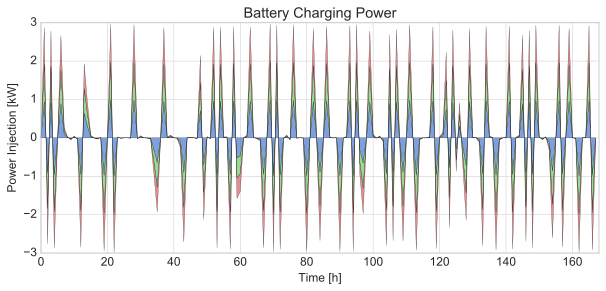

In [157]:
%aimport pfvis

pfvis.plot_battery_power(mp)


## Energy Price

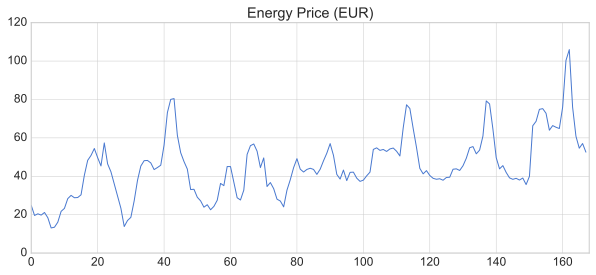

In [158]:
pfvis.plot_energy_price(mp)

## Load Power

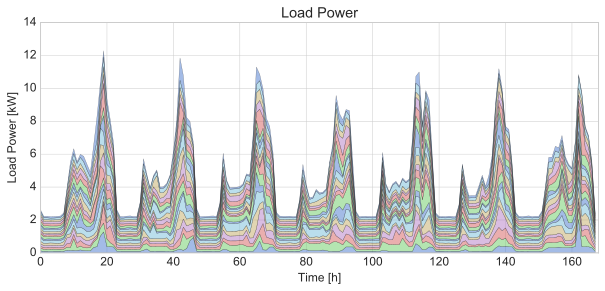

In [159]:
pfvis.plot_load_power(mp)

## Vargen Injection

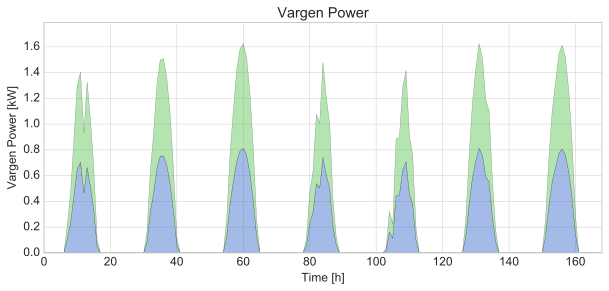

In [160]:
pfvis.plot_vargen_injection(mp)

## Plot Network Graph

In [161]:
#g = pfnet.Graph(mp.networks[0])
#for bus in mp.networks[0].buses:
#    g.set_node_property(bus,b"label",str(bus.number).encode('UTF-8'))
#g.set_layout()    
#g.view(inline=True)

# Distributed Approach

In [162]:
a_mats = p.get_coupling_A()

a = scipy.sparse.hstack([a for a in a_mats.values()])

print(a.shape)

(31, 155)


In [163]:
p.problems[0].A

<52x58 sparse matrix of type '<class 'numpy.float64'>'
	with 164 stored elements in COOrdinate format>

In [164]:
net = mp.get_network()
bus = net.buses[0]
bus.show()

In [165]:
xhat = proj * p.problems[0].x
print(xhat.shape)

NameError: name 'proj' is not defined

In [ ]:
p.problems[0].b.shape

In [ ]:
Ahat = a * proj.transpose()
Ahat.shape
Ahat * xhat - p.problems[0].b

In [ ]:
adj = mp.get_adjacency_matrix()
from optalg.opt_solver.decoupled_problem import DecoupledProblem
from optalg.opt_solver import OptSolverDPDG

dp = DecoupledProblem(None, None, adj)
solver = OptSolverDPDG()
solver.solve(dp)